In [4]:
# =============================================================
# A. IMPORT THƯ VIỆN
# =============================================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns




In [5]:
# =============================================================
# B. ĐỌC DỮ LIỆU
# =============================================================
file_path = "C:/Python code/cleaned_data_part_2_official.csv"
df = pd.read_csv(file_path)

print("✅ Dữ liệu tải thành công:", df.shape)
df.columns = df.columns.str.strip().str.replace(" ", "_")
print(df.head())

✅ Dữ liệu tải thành công: (1058, 11)
          Make       Car_Name  CC_Capacity  Horsepower  Top_Speed_kmh  \
0      FERRARI  Sf90 Stradale       3990.0       963.0          340.0   
1  ROLLS ROYCE        Phantom       6749.0       563.0          250.0   
2         FORD            Ka+       1200.0        77.5          165.0   
3     MERCEDES        Gt 63 S       3982.0       630.0          250.0   
4         AUDI     Audi R8 Gt       5204.0       602.0          320.0   

   Acceleration_0_100_sec  Price_USD  Seats  Torque_Nm Engine_Layout  \
0                     2.5  1100000.0      2      800.0        V-type   
1                     5.3   460000.0      5      900.0        V-type   
2                    10.5    13500.0      5      120.0        Inline   
3                     3.2   161000.0      4      900.0        V-type   
4                     3.6   253290.0      2      560.0        V-type   

  Fuel_Type_Cleaned  
0            Hybrid  
1            Petrol  
2            Petrol  
3  

In [6]:

# =============================================================
# C. BIẾN MỤC TIÊU (TARGET)
# =============================================================
target_col = 'Price_USD'
if target_col not in df.columns:
    print(f"⚠️ Không thấy cột '{target_col}' trong dữ liệu. Các cột hiện có:")
    print(df.columns.tolist())
else:
    df = df.dropna(subset=[target_col])

    # =============================================================
    # D. TÁCH DỮ LIỆU ĐẦU VÀO / ĐẦU RA
    # =============================================================
    y = df[target_col]
    X = df.drop(columns=[target_col])

    # Xác định kiểu biến
    num_cols = ['CC_Capacity', 'Horsepower', 'Top_Speed_kmh',
                'Acceleration_0_100_sec', 'Seats', 'Torque_Nm']
    cat_cols = ['Make', 'Car_Name', 'Engine_Layout', 'Fuel_Type_Cleaned']

    # =============================================================
    # E. TIỀN XỬ LÝ
    # =============================================================
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ])

# =============================================================
# F. CHIA TRAIN / VAL / TEST
# =============================================================
from sklearn.model_selection import train_test_split

# 1️⃣ Chia 80% train+val và 20% test
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 2️⃣ Từ 80% train_full chia tiếp 80/20 cho train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

print("📊 Kích thước dữ liệu:")
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


📊 Kích thước dữ liệu:
Train: (676, 10)
Val: (170, 10)
Test: (212, 10)


In [7]:
# =============================================================
# G. CÁC MÔ HÌNH DỰ ĐOÁN
# =============================================================
models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42),
        "XGBoost": XGBRegressor(
            n_estimators=300,
            learning_rate=0.1,
            max_depth=8,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective="reg:squarederror",   # vẫn giữ nguyên
            eval_metric="rmse"
            
        )
    }


⚙️ Numeric columns: ['CC_Capacity', 'Horsepower', 'Top_Speed_kmh', 'Acceleration_0_100_sec', 'Seats', 'Torque_Nm']
🏷️ Categorical columns: ['Make', 'Car_Name', 'Engine_Layout', 'Fuel_Type_Cleaned']

🚀 Training: Linear Regression

🚀 Training: Ridge

🚀 Training: Lasso

🚀 Training: Decision Tree

🚀 Training: Random Forest

🚀 Training: SVM

🚀 Training: XGBoost

📊 Model Comparison (Chen, 2024):
            Model           MAE          RMSE        R2
    Random Forest  23837.515239  94271.168393  0.955304
    Decision Tree  26567.345135 121462.761290  0.925802
            Ridge  79838.087343 122077.607902  0.925049
          XGBoost  34124.911064 148461.185398  0.889151
Linear Regression  93770.185785 196946.649423  0.804923
            Lasso 125562.052568 219089.070463  0.758593
              SVM 107066.781055 455172.349389 -0.041980


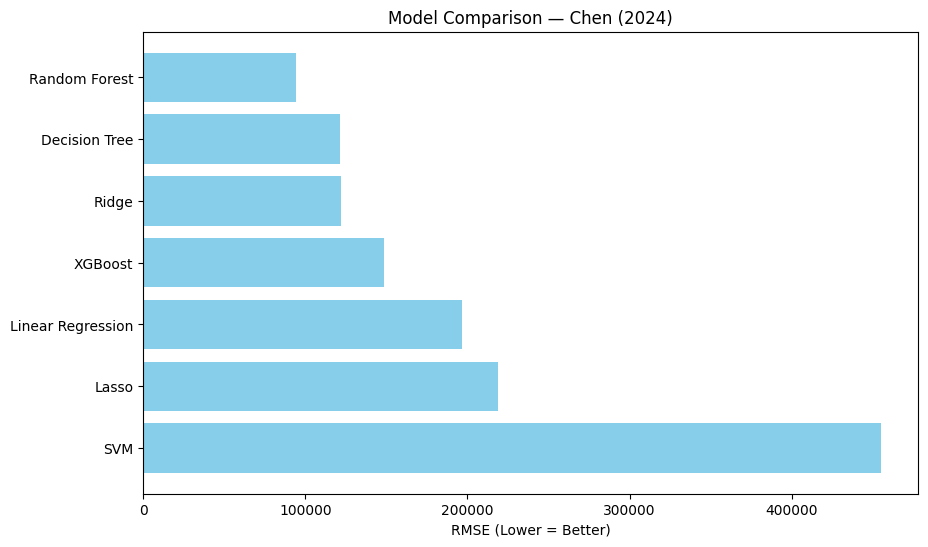

In [14]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")



# ============================================================
# 2️⃣ CHUẨN BỊ DỮ LIỆU
# ============================================================
target_candidates = ["price", "new_price", "Price_USD"]
target = None
for col in target_candidates:
    if col in df.columns:
        target = col
        break
if target is None:
    raise ValueError("❌ Không tìm thấy cột giá (price/new_price/Price_USD).")

X = df.drop(columns=[target])
y = df[target]

num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

print("⚙️ Numeric columns:", num_cols)
print("🏷️ Categorical columns:", cat_cols)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# ============================================================
# 3️⃣ CÁC MÔ HÌNH THEO BÀI BÁO
# ============================================================
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42),
    "SVM": SVR(kernel='rbf', C=10, epsilon=0.2),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    )
}

# ============================================================
# 4️⃣ TRAIN & EVALUATE
# ============================================================
results = []
for name, model in models.items():
    print(f"\n🚀 Training: {name}")
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})

# ============================================================
# 5️⃣ KẾT QUẢ
# ============================================================
results_df = pd.DataFrame(results).sort_values(by="RMSE")
print("\n📊 Model Comparison (Chen, 2024):")
print(results_df.to_string(index=False))

# ============================================================
# 6️⃣ BIỂU ĐỒ SO SÁNH
# ============================================================
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(results_df["Model"], results_df["RMSE"], color="skyblue")
plt.xlabel("RMSE (Lower = Better)")
plt.title("Model Comparison — Chen (2024)")
plt.gca().invert_yaxis()
plt.show()
